Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_resnet"
showListOfSpecies = False

from configParser import ConfigParser, getModelName
config_parser = ConfigParser(experimentName)

import os
experimentName = os.path.join(experimentName, "multi-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)
ts_genus = TrialStatistics.TrialStatistics(experimentName, "genus")

import dataLoader

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from confusion_matrix_plotter import plot_confusion_matrix2, generate_classification_report
import numpy as np
import os
import progressbar

paramsIterator = config_parser.getHyperpIter()  
number_of_experiments = sum(1 for e in paramsIterator)
paramsIterator = config_parser.getHyperpIter()  
experiment_index = 0

datasetManager = dataLoader.datasetManager(experimentName, showListOfSpecies)
with progressbar.ProgressBar(max_value=number_of_experiments) as bar:
    for experiment_params in paramsIterator:
        bar.update(experiment_index)
        experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1

        print("experiment ", experiment_index+1, "/", number_of_experiments, ": ", experiment_params)

        # load images
        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
        speciesList = dataset.getSpeciesList()
        numberOfSpecies = len(speciesList)
        numberOfGenus = len(dataset.getGenusList())

        confusionMatricesPerTrial = []

        for i in range(experiment_params["numOfTrials"]):
            trialName = os.path.join(experimentName, getModelName(experiment_params, i))

            # Train/Load model
            architecture = {
                "species": numberOfSpecies,
                "genus" : numberOfGenus
            }
            model = CNN.create_model(architecture, experiment_params)
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            if os.path.exists(CNN.getModelFile(trialName)):
                _, _, epochs, time_elapsed = CNN.loadModel(model, trialName)
                print("Model {0} loaded!".format(trialName))
            else:
                _, _, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, experiment_params, model, trialName)
            
            # Update trial outcomes for statistics
            predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params)
            ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)
            macro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')
            macro_f1_genus = np.nan
            if experiment_params["useHeirarchy"]:
                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params, 'genus')
                ts_genus.addTrialPredictions(experiment_params, predlist, lbllist, numberOfGenus)
                macro_f1_genus = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

            ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, experiment_params),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model, experiment_params),
                     'macro_f1_species': macro_f1,
                     'macro_f1_genus': macro_f1_genus,
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
        
        experiment_index = experiment_index + 1

N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  1 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': True, 'resnet': '18', 'normalize': True}
Loading dataset...
Going through image files


100% (550 of 550) |######################| Elapsed Time: 0:00:41 Time:  0:00:41


dataset has a mean: tensor([0.7661, 0.7249, 0.6513]) and std: tensor([0.1420, 0.1753, 0.2096])
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/dataset.pkl written
Loading saved indices...
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/trainingIndex.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/valIndex.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/testIndex.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/trainingLoader.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/valLoader.pkl writte

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_resnet/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/testLoader.pkl written
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 2:48:39 Time:  2:48:39


Early stopping
total number of epochs:  797


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:27:38 Time:  3:27:38
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:18:28 Time:  3:18:28
 25% (1 of 4) |######                    | Elapsed Time: 9:36:55 ETA:  20:20:11

experiment  2 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': True, 'resnet': '50', 'normalize': True}


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


 25% (1 of 4) |####               | Elapsed Time: 11:28:19 ETA:  1 day, 1:54:24

Early stopping


100% (1000 of 1000) |####################| Elapsed Time: 1:51:24 Time:  1:51:24


total number of epochs:  547


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


 25% (1 of 4) |####              | Elapsed Time: 14:40:06 ETA:  1 day, 11:29:44

Early stopping


100% (1000 of 1000) |####################| Elapsed Time: 3:11:34 Time:  3:11:34


total number of epochs:  937


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


 25% (1 of 4) |####              | Elapsed Time: 16:54:14 ETA:  1 day, 18:12:07

Early stopping


100% (1000 of 1000) |####################| Elapsed Time: 2:13:55 Time:  2:13:55


total number of epochs:  647


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  3 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': True, 'resnet': '18', 'normalize': True}
using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 2:51:27 Time:  2:51:27


Early stopping
total number of epochs:  848


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:00:42 Time:  3:00:42


Early stopping
total number of epochs:  893


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 2:12:37 Time:  2:12:37


Early stopping
total number of epochs:  687


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  4 / 4 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': True, 'resnet': '50', 'normalize': True}
using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 2:22:08 Time:  2:22:08


Early stopping
total number of epochs:  744
using a pretrained resnet model...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 1:32:50 Time:  1:32:50


Early stopping
total number of epochs:  481
using a pretrained resnet model...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 1:18:45 Time:  1:18:45


Early stopping
total number of epochs:  407


100% (4 of 4) |#############| Elapsed Time: 1 day, 6:13:53 Time: 1 day, 6:13:53


Analyze

In [5]:
ts.showStatistics()
ts.saveStatistics()

Aggregated statistics


In [6]:
ts.showStatistics(False)
ts.saveStatistics(False)

Raw statistics


,image_path,suffix,training_count,validation_count,imageDimension,n_channels,augmentation,batchSize,n_epochs,learning_rate,numOfTrials,patience,useHeirarchy,useRelu,downsample,downsampleOutput,takeFromIntermediate,takeFromIntermediateOutput,useAdam,resnet,normalize,loss,accuracy,macro_f1_species,macro_f1_genus,time,epochs,hash,trial
0,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,True,False,True,50,True,50,True,18,True,0.551367,0.809091,0.807945,0.836866,10119.258113,798,-6531791378853013498,0
1,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,True,False,True,50,True,50,True,18,True,0.632870,0.781818,0.780563,0.871890,12458.770264,1000,-6531791378853013498,1
2,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,True,False,True,50,True,50,True,18,True,0.581985,0.800000,0.800240,0.878788,11908.153838,1000,-6531791378853013498,2
3,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,True,False,True,50,True,50,True,50,True,0.705120,0.745455,0.744294,0.620909,6684.002129,548,-9152207393364617717,0
4,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,True,False,True,50,True,50,True,50,True,0.710055,0.781818,0.780061,0.899935,11494.072799,938,-9152207393364617717,1
5,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,True,False,True,50,True,50,True,50,True,0.653699,0.781818,0.781878,0.298643,8035.247251,648,-9152207393364617717,2
6,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,False,False,True,50,True,50,True,18,True,0.818825,0.772727,0.735735,NaN,10287.495625,849,-3863746956200108666,0
7,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,False,False,True,50,True,50,True,18,True,1.275639,0.581818,0.495970,NaN,10842.575058,894,-3863746956200108666,1
8,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,False,False,True,50,True,50,True,18,True,1.044797,0.727273,0.692929,NaN,7957.696410,688,-3863746956200108666,2
9,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,200,1000,0.0001,3,100,False,False,True,50,True,50,True,50,True,0.921361,0.690909,0.660860,NaN,8528.863773,745,-8120143210267186293,0


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': True, 'resnet': '18', 'normalize': True}


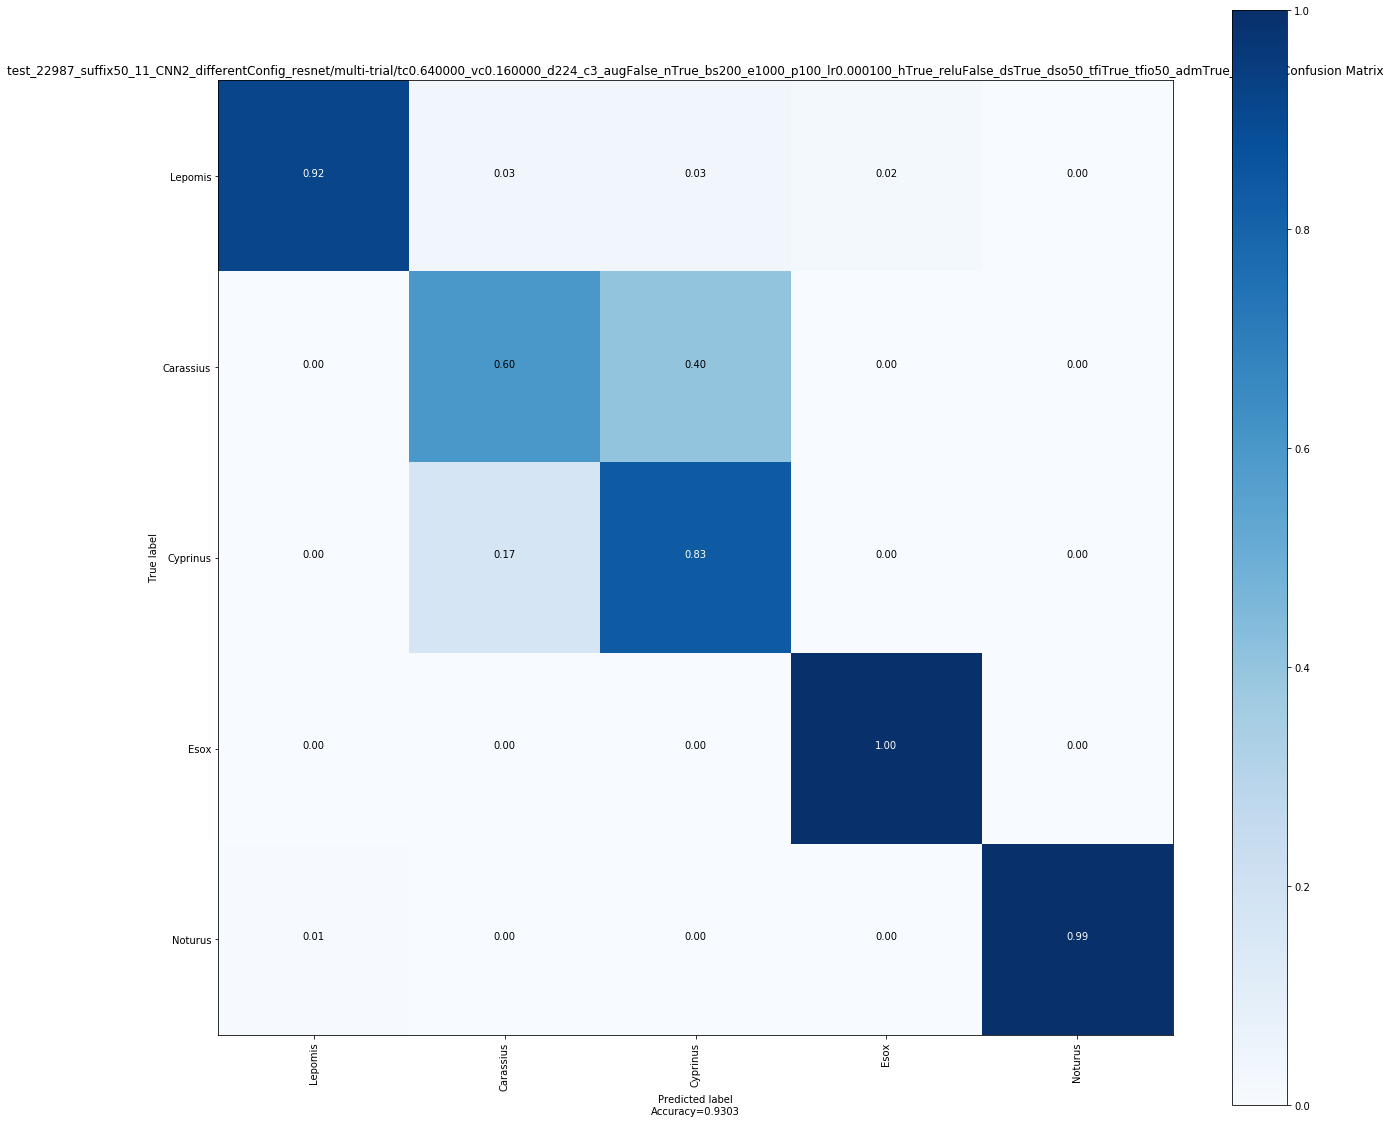

,genus,F1
0,0 Lepomis,0.948276
1,1 Carassius,0.654545
2,2 Cyprinus,0.724638
3,3 Esox,0.991736
4,4 Noturus,0.996656


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': True, 'resnet': '50', 'normalize': True}


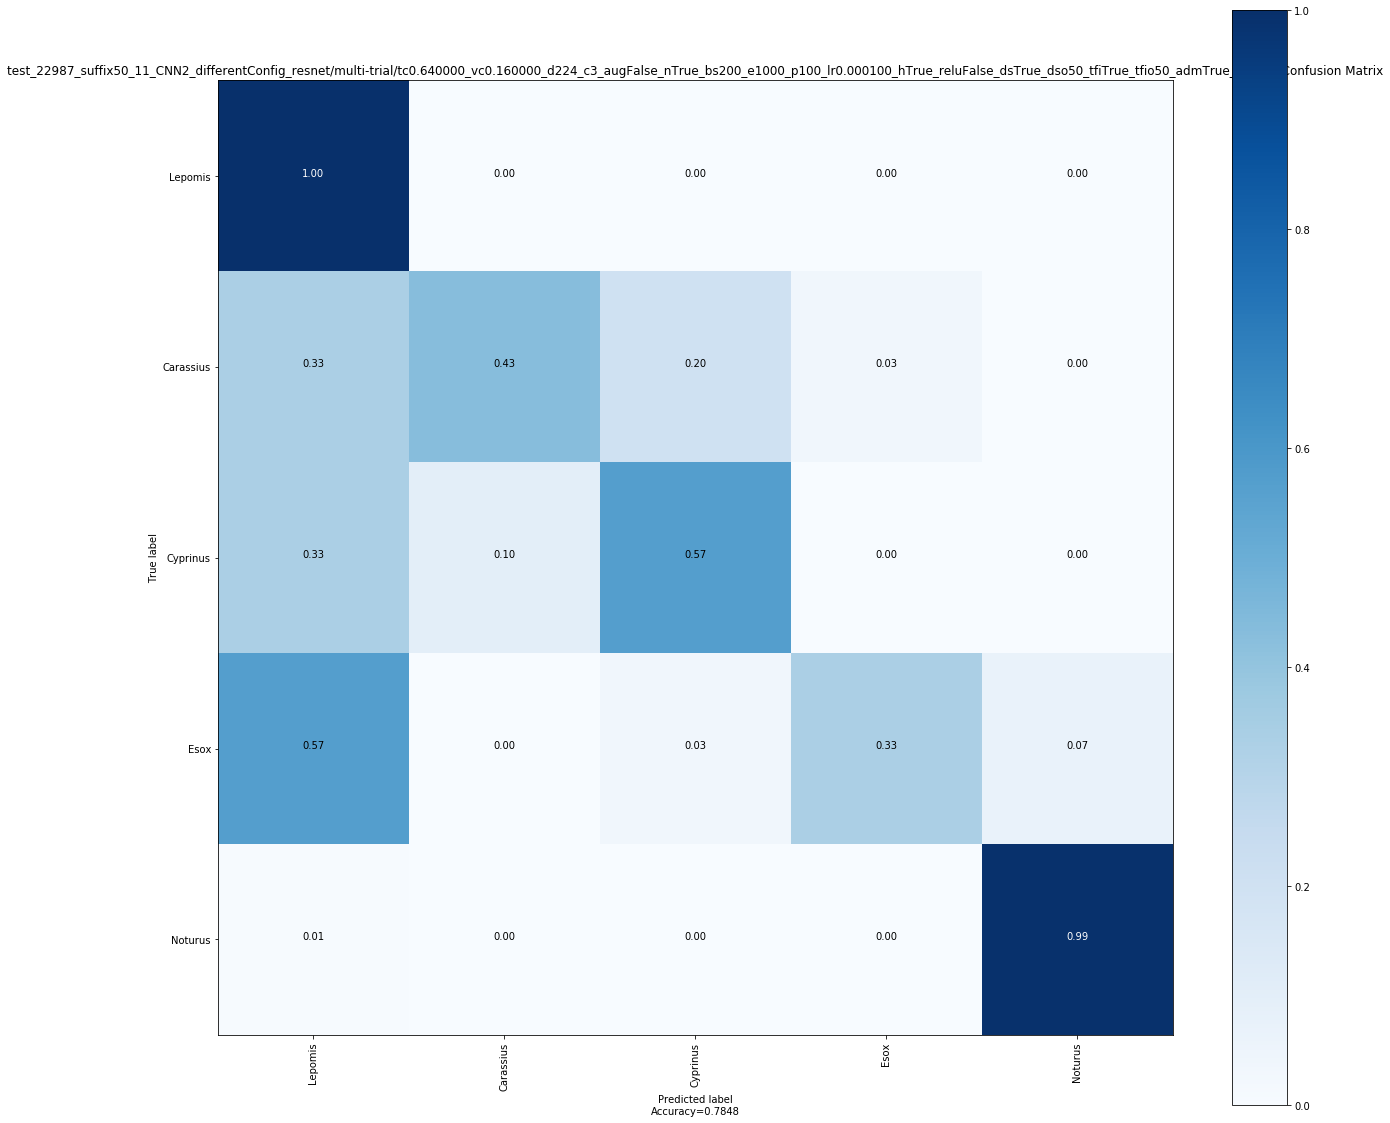

,genus,F1
0,0 Lepomis,0.685714
1,1 Carassius,0.565217
2,2 Cyprinus,0.618182
3,3 Esox,0.493827
4,4 Noturus,0.983498


In [7]:
paramsIterator = config_parser.getHyperpIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    if experiment_params["useHeirarchy"]:
        print("experiment: ", experiment_params)

        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
    
        genusList = dataset.getGenusList()
        ts_genus.printTrialConfusionMatrix(experiment_params, genusList, True)
        ts_genus.printF1table(experiment_params, dataset)

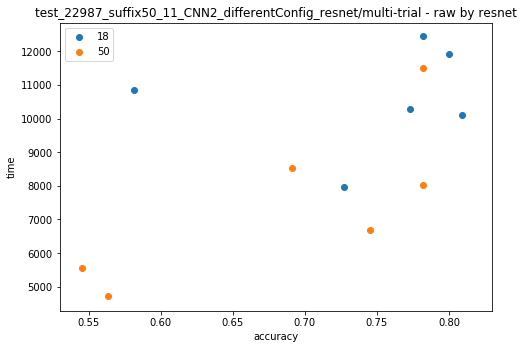

In [9]:
ts.trialScatter('accuracy', 'time', False, 'resnet')

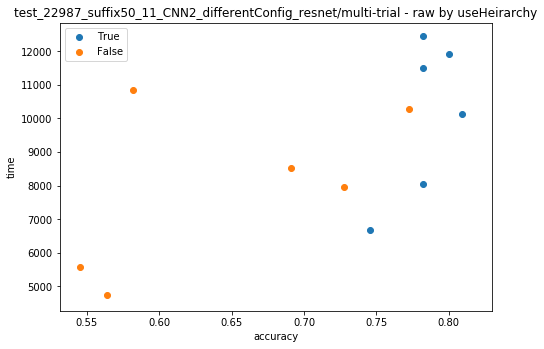

In [11]:
ts.trialScatter('accuracy', 'time', False, 'useHeirarchy')